In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score

In [3]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


In [4]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [5]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [7]:
categorical_cols = df.select_dtypes('object').columns.tolist()
numerical_cols = [c for c in df.columns if c not in categorical_cols + ['converted']]

In [8]:
df[categorical_cols] = df[categorical_cols].fillna('NA')
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)
df['converted'] = df['converted'].astype(int)

In [9]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, stratify=df['converted'], random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, stratify=df_full_train['converted'], random_state=1)

In [11]:
features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_scores = {}

for v in features:
    vals = df_train[v].values
    auc = roc_auc_score(df_train['converted'], vals)
    if auc < 0.5:
        auc = roc_auc_score(df_train['converted'], -vals)
    auc_scores[v] = auc

for f, s in auc_scores.items():
    print(f"  {f}: {s:.3f}")


  lead_score: 0.618
  number_of_courses_viewed: 0.752
  interaction_count: 0.706
  annual_income: 0.567


In [12]:
best_var = max(auc_scores, key=auc_scores.get)
best_var

'number_of_courses_viewed'

### Best AUC is number of course viewed

In [13]:
dv = DictVectorizer(sparse=False)
train_dict = df_train.drop('converted', axis=1).to_dict(orient='records')
val_dict = df_val.drop('converted', axis=1).to_dict(orient='records')

In [14]:
X_trainain = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
y_trainain = df_train['converted'].values
y_val = df_val['converted'].values

In [15]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_trainain, y_trainain)
y_pred = model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred)
round(val_auc, 3)

np.float64(0.9)

### the AUC of this model on the validation dataset is 0.9

In [16]:
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls   = []

for t in thresholds:
    preds = (y_pred >= t).astype(int)
    precisions.append(precision_score(y_val, preds, zero_division=0))
    recalls.append(recall_score(y_val, preds))



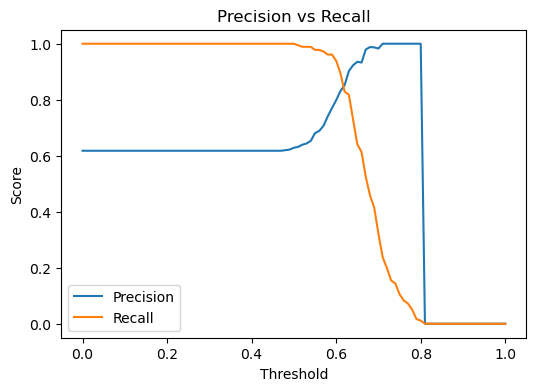

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision vs Recall')
plt.show()

In [18]:
diff = np.abs(np.array(precisions) - np.array(recalls))
best_idx = np.argmin(diff)
best_threshold = thresholds[best_idx]
round(best_threshold,3)

np.float64(0.81)

### threshold precision and recall curves intersect at 0.81

In [19]:
f1_scores = [2*p*r/(p+r) if (p+r) > 0 else 0 for p, r in zip(precisions, recalls)]
best_f1_t = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)
round(best_f1, 3)

np.float64(0.863)

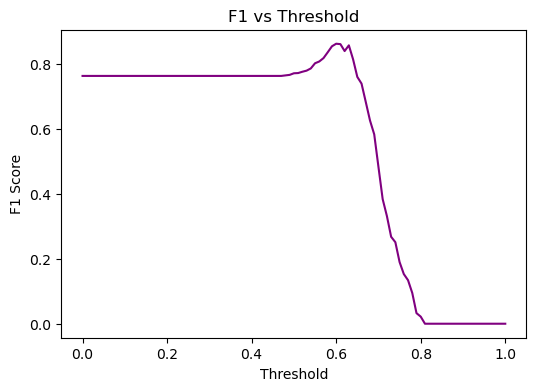

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores, color='purple')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 vs Threshold')
plt.show()

### threshold F1 is maximal :0.6

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
aucs = []
for train_idx, val_idx in kf.split(df_full_train):
    train = df_full_train.iloc[train_idx]
    validation = df_full_train.iloc[val_idx]
    dv_fold = DictVectorizer(sparse=False)
    X_train = dv_fold.fit_transform(train.drop('converted', axis=1).to_dict(orient='records'))
    X_val = dv_fold.transform(validation.drop('converted', axis=1).to_dict(orient='records'))
    y_train = train['converted'].values
    y_val = validation['converted'].values

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    aucs.append(roc_auc_score(y_val, y_pred))

round(np.std(aucs), 3)

np.float64(0.029)

### the large standard deviation of the scores across different folds is 0.029

In [22]:
C_values = [0.000001, 0.001, 1]
results = {}
for C in C_values:
    scores = []
    for train_idx, val_idx in kf.split(df_full_train):
        train = df_full_train.iloc[train_idx]
        validation = df_full_train.iloc[val_idx]
        dv_fold = DictVectorizer(sparse=False)
        X_train = dv_fold.fit_transform(train.drop('converted', axis=1).to_dict(orient='records'))
        X_val = dv_fold.transform(validation.drop('converted', axis=1).to_dict(orient='records'))
        y_train = train['converted'].values
        y_val = validation['converted'].values

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        scores.append(roc_auc_score(y_val, y_pred))
    results[C] = (np.mean(scores), np.std(scores))

for C, (mean_auc, std_auc) in results.items():
    print(f"C={C}: mean={round(mean_auc,3)}, std={round(std_auc,3)}")

best_C = max(results, key=lambda c: (results[c][0], -results[c][1], -c))
best_C

C=1e-06: mean=0.561, std=0.035
C=0.001: mean=0.86, std=0.026
C=1: mean=0.817, std=0.029


0.001

### C leads to the best mean score is 0.001